<center><h1>KIM_GUKIL_HW8</h1></center>

Name: GUK IL KIM 
<br>
Github Username: DanielKim12
<br>
USC ID: 3020867072

## 1. Supervised, Semi-Supervised, and Unsupervised Learning

Import packages

In [61]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC, LinearSVC
from scipy.special import softmax
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.pairwise import rbf_kernel
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import joblib

import warnings
warnings.filterwarnings("ignore")

### (a) Download the Breast Cancer Wisconsin (Diagnostic) Data Set

convert to csv to extract data 

In [ ]:
sed 's/ \+/,/g' wdbc.data > wdbc.csv

In [127]:
df = pd.read_csv("./data/wdbc.csv", header = None)
df.replace({'M': 1, 'B': 0}, inplace = True)
df.columns = ['id', 'label'] + [f'attribute{i}' for i in range(1, 31)] # 30 attributes
df.head()

,id,label,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,...,attribute21,attribute22,attribute23,attribute24,attribute25,attribute26,attribute27,attribute28,attribute29,attribute30
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


### (b) Monte-Carlo Simulation

In [45]:
# to split data 20% test and 80% train
def split_data(df, label_col='label', id_col='id', test_size=0.2, random_state=None):
    if random_state: 
        np.random.seed(random_state)
    # label and id
    label_idx = df.columns.get_loc(label_col)
    id_idx = df.columns.get_loc(id_col)
    # seperate positive and negative samples
    pos_samples = df[df[label_col] == 1]
    neg_samples = df[df[label_col] == 0]
    pos_test_size = int(len(pos_samples) * test_size)
    neg_test_size = int(len(neg_samples) * test_size)
    # shuffle and select test samples
    pos_test_indices = np.random.choice(pos_samples.index, pos_test_size, replace=False)
    neg_test_indices = np.random.choice(neg_samples.index, neg_test_size, replace=False)
    test_indices = np.concatenate([pos_test_indices, neg_test_indices])
    train_indices = df.index.difference(test_indices)
    # select features and labels
    feature_indices = list(range(df.shape[1]))
    feature_indices.remove(label_idx)
    feature_indices.remove(id_idx)
    # use iloc to select data
    x_train = df.iloc[train_indices, feature_indices]
    y_train = df.iloc[train_indices, label_idx]
    x_test = df.iloc[test_indices, feature_indices]
    y_test = df.iloc[test_indices, label_idx]
    return x_train, x_test, y_train, y_test

In [46]:
def normalize_data(x_train, x_test, method='standard'): # to normalize data
    if method == 'minmax':
        scaler = MinMaxScaler()
    elif method == 'standard':
        scaler = StandardScaler()
    else:
        raise ValueError("Invalid method. Use 'standard' or 'minmax'.")
    x_train_norm = scaler.fit_transform(x_train)
    x_test_norm = scaler.transform(x_test)
    return x_train_norm, x_test_norm

In [47]:
def plot_roc_curve(y_true, y_score, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', color='red')  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show() 

In [48]:
def analyze_model_performance(model, X, y, title="Model Performance", plot_roc=False):
    y_pred = model.predict(X)
    # decision_function or predict_proba based on the model
    if hasattr(model, "decision_function"):
        y_score = model.decision_function(X)
    elif hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X)[:, 1]
    else:
        raise AttributeError("Model does not support decision_function or predict_proba.")

    # get metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc_score = roc_auc_score(y, y_score)
    conf_matrix = confusion_matrix(y, y_pred)

    # only plot ROC curve if plot_roc is True, this is to avoid plotting ROC curve for every model
    if plot_roc:
        print(f"Accuracy Score for {title}: {accuracy:.4f}")
        print(f"Confusion Matrix for {title}:\n{conf_matrix}\n")
        plot_roc_curve(y_true=y, y_score=y_score, title=f"ROC Curve for {title}\n")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc_score
    } 

In [55]:
def summarize_metrics(train_metrics, test_metrics):
    # averages
    train_avg = train_metrics.mean()
    test_avg = test_metrics.mean()
    # combine averages into a single DataFrame
    summary_df = pd.DataFrame({
        "Train Average": train_avg,
        "Test Average": test_avg
    })

    summary_df.index = [metric.capitalize() for metric in summary_df.index]  # capitalize metric names
    summary_df = summary_df.round(4)  # Round values to 4 decimal places
    print("\nSummary of Average Metrics:")
    display(summary_df)  # Display nicely in Jupyter Notebook
    return summary_df

In [50]:
# model for supervised learning and semi-supervised learning
def run_svm(df_train, iters=30, test_size=0.2, random_state=None, normalize_method='standard', learning_type='supervised'):
    stats = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
    train_metrics = pd.DataFrame(columns=stats)
    test_metrics = pd.DataFrame(columns=stats)
    print("Iteration\tTrain Accuracy\tTest Accuracy\tBest Params")
    last_model = None
    last_x_train, last_x_test, last_y_train, last_y_test = None, None, None, None

    for i in range(iters):
        # split data
        x_train, x_test, y_train, y_test = split_data(
            df_train, test_size=test_size, random_state=random_state + i if random_state else None
        )
        x_train, x_test = normalize_data(x_train, x_test, method=normalize_method)

        # parameter grid for SVM
        param_grid = {'C': np.logspace(-2, 3, 10)} # 10 values between 0.01 and 1000
        grid_args = {
            'param_grid': param_grid,
            'scoring': 'f1_weighted',
            'cv': StratifiedKFold(3, shuffle=True, random_state=i),
            'n_jobs': 1
        }

        # condition for supervised and semi-supervised learning
        if learning_type == 'supervised':
            # train SVM in supervised mode
            model = GridSearchCV(estimator=SVC(kernel='linear', probability=True), **grid_args)
            model.fit(x_train, y_train)
        elif learning_type == 'semi-supervised':
            # semi-supervised learning with self-training
            labeled_indices = []
            unlabeled_indices = []

            # 50% of each class is labeled
            for label in [0, 1]:
                label_indices = np.where(y_train == label)[0]
                labeled_indices.extend(
                    np.random.choice(label_indices, round(len(label_indices) * 0.5), replace=False)
                )
            unlabeled_indices = [i for i in range(len(x_train)) if i not in labeled_indices]
            x_labeled = x_train[labeled_indices]
            y_labeled = y_train.iloc[labeled_indices].to_numpy()
            x_unlabeled = x_train[unlabeled_indices]
            # train initial model on labeled data
            model = GridSearchCV(estimator=LinearSVC(penalty='l1', dual=False), **grid_args)
            model.fit(x_labeled, y_labeled)

            # self-training loop
            while len(x_unlabeled) > 0:
                # calculate distances to the decision boundary
                scores = model.decision_function(x_unlabeled)
                # farthest point from the decision boundary
                farthest_index = np.argmax(np.abs(scores))
                x_labeled = np.vstack([x_labeled, x_unlabeled[farthest_index]])
                y_labeled = np.append(y_labeled, model.predict(x_unlabeled[farthest_index].reshape(1, -1)))
                # remove the point from the unlabeled dataset
                x_unlabeled = np.delete(x_unlabeled, farthest_index, axis=0)
                # retrain the model on the updated labeled dataset
                model.best_estimator_.fit(x_labeled, y_labeled)
        else:
            raise ValueError("Invalid learning_type. Choose 'supervised' or 'semi-supervised'.")

        # summary
        train_results = analyze_model_performance(model, x_train, y_train, plot_roc=False)
        test_results = analyze_model_performance(model, x_test, y_test, plot_roc=False)
        train_metrics = train_metrics.append(train_results, ignore_index=True)
        test_metrics = test_metrics.append(test_results, ignore_index=True)

        # save the model and data for the last iteration
        if i == iters - 1:
            last_model = model
            last_x_train, last_x_test, last_y_train, last_y_test = x_train, x_test, y_train, y_test

        print(f"{i + 1}\t\t{train_results['accuracy']:.4f}\t\t{test_results['accuracy']:.4f}\t\t{model.best_params_ if hasattr(model, 'best_params_') else 'N/A'}")

    print("\nFinal Performance Analysis for Last Iteration:")
    analyze_model_performance(last_model, last_x_train, last_y_train, title="Final Training Performance", plot_roc=True)
    analyze_model_performance(last_model, last_x_test, last_y_test, title="Final Testing Performance", plot_roc=True)
    summary = summarize_metrics(train_metrics, test_metrics)
    return summary

#### (i) Supervised Learning

In [51]:
x_train, x_test, y_train, y_test = split_data(df, label_col='label', test_size=0.2, random_state=0)
#x_train.head()

In [52]:
#x_test.head()

In [53]:
# display(y_train.value_counts())
# display(y_test.value_counts())

Iteration	Train Accuracy	Test Accuracy	Best Params
1		0.9759		0.9735		{'C': 0.03593813663804628}
2		0.9825		0.9735		{'C': 0.03593813663804628}
3		0.9846		0.9735		{'C': 0.03593813663804628}
4		0.9868		0.9469		{'C': 0.464158883361278}
5		0.9890		0.9735		{'C': 0.464158883361278}
6		0.9890		0.9646		{'C': 0.464158883361278}
7		0.9912		0.9558		{'C': 0.1291549665014884}
8		0.9781		0.9912		{'C': 0.03593813663804628}
9		0.9912		0.9646		{'C': 1.6681005372000592}
10		0.9868		0.9646		{'C': 0.1291549665014884}
11		0.9912		0.9646		{'C': 0.464158883361278}
12		0.9846		0.9912		{'C': 0.1291549665014884}
13		0.9825		0.9912		{'C': 0.1291549665014884}
14		0.9868		0.9823		{'C': 0.464158883361278}
15		0.9803		0.9912		{'C': 0.1291549665014884}
16		0.9846		0.9912		{'C': 0.1291549665014884}
17		0.9868		0.9823		{'C': 0.03593813663804628}
18		0.9890		0.9735		{'C': 0.1291549665014884}
19		0.9868		0.9558		{'C': 0.03593813663804628}
20		0.9846		0.9823		{'C': 0.1291549665014884}
21		0.9846		0.9823		{'C': 0.464158883

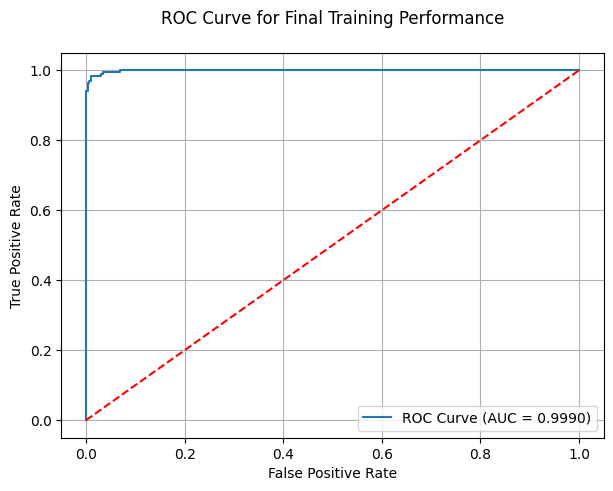

Accuracy Score for Final Testing Performance: 0.9823
Confusion Matrix for Final Testing Performance:
[[71  0]
 [ 2 40]]



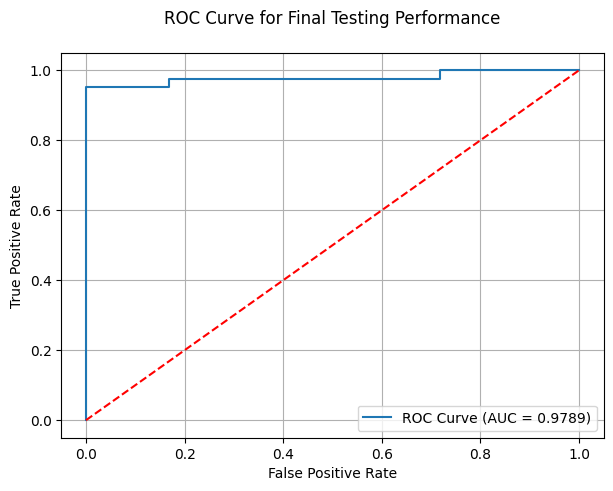


Summary of Average Metrics:


,Train Average,Test Average
Accuracy,0.9859,0.9752
Precision,0.9930,0.9848
Recall,0.9690,0.9484
F1_score,0.9808,0.9659
Auc,0.9968,0.9941


In [56]:
supervised_results = run_svm(df, iters=30, random_state=42, learning_type='supervised')

#### (ii) Semi-Supervised Learning/ Self-training

##### (A) & (B)

Iteration	Train Accuracy	Test Accuracy	Best Params
1		0.9803		0.9558		{'C': 0.1291549665014884}
2		0.9781		0.9735		{'C': 0.03593813663804628}
3		0.9846		0.9558		{'C': 77.42636826811278}
4		0.9693		0.9204		{'C': 0.464158883361278}
5		0.9737		0.9646		{'C': 0.464158883361278}
6		0.9759		0.9735		{'C': 0.1291549665014884}
7		0.9825		0.9646		{'C': 5.994842503189409}
8		0.9737		1.0000		{'C': 0.1291549665014884}
9		0.9759		0.9646		{'C': 0.1291549665014884}
10		0.9803		0.9558		{'C': 1000.0}
11		0.9693		0.9646		{'C': 0.03593813663804628}
12		0.9649		1.0000		{'C': 0.03593813663804628}
13		0.9781		0.9558		{'C': 1000.0}
14		0.9627		0.9646		{'C': 0.1291549665014884}
15		0.9781		1.0000		{'C': 0.464158883361278}
16		0.9671		0.9823		{'C': 1.6681005372000592}
17		0.9781		0.9646		{'C': 0.464158883361278}
18		0.9781		0.9558		{'C': 5.994842503189409}
19		0.9890		0.9735		{'C': 0.464158883361278}
20		0.9737		0.9823		{'C': 0.1291549665014884}
21		0.9803		0.9381		{'C': 77.42636826811278}
22		0.9868		0.9558		{'

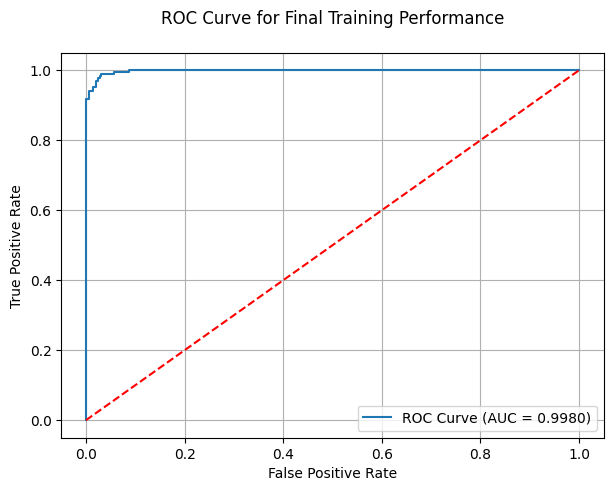

Accuracy Score for Final Testing Performance: 0.9558
Confusion Matrix for Final Testing Performance:
[[70  1]
 [ 4 38]]



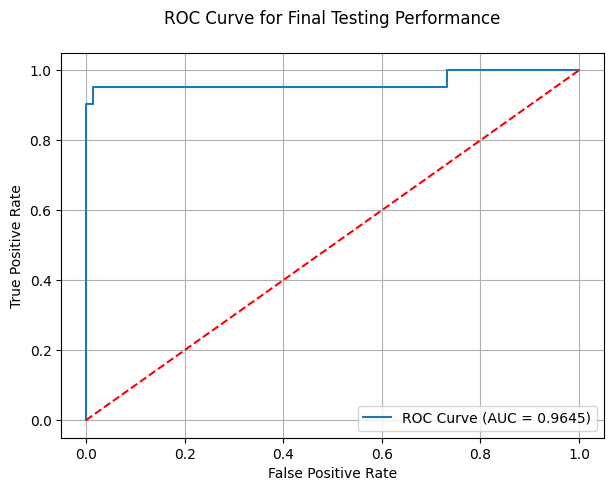


Summary of Average Metrics:


,Train Average,Test Average
Accuracy,0.9760,0.9652
Precision,0.9813,0.9702
Recall,0.9539,0.9357
F1_score,0.9672,0.9522
Auc,0.9946,0.9902


In [57]:
semi_supervised_results = run_svm(df, iters=30, random_state=42, learning_type='semi-supervised')

#### (iii) Unsupervised Learning

##### (A)

To make sure that algorithm was not trapped in local minimum, there are few solutions to avoid this. 
- Change the learning rate: A smaller learning rate may help the model to escape from the local minimum.
- Use alternate algorithm: Using a different optimization method, such as stochastic gradient descent (SGD) or momentum, might be more effective in avoiding local minima.
- Incorporate regularization: Regularization helps prevent the model from overfitting the training data and reduces the likelihood of getting stuck in a local minimum.

##### (B)

In [73]:
# for unsupervised learning with KMeans and Spectral Clustering summary
def analyze_model_performance_kmeans(y_true, y_pred, y_score=None, title="Model Performance", plot_roc=False):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_score = roc_auc_score(y_true, y_score) if y_score is not None else None
    conf_matrix = confusion_matrix(y_true, y_pred)

    if plot_roc and y_score is not None:
        print(f"Accuracy Score for {title}: {accuracy:.4f}")
        print(f"\nConfusion Matrix for {title}:\n{conf_matrix}")
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
        plt.plot([0, 1], [0, 1], 'k--', color='red')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(title)
        plt.legend(loc="lower right")
        plt.grid()
        plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc_score
    }

In [59]:
def plot_roc_curve_kmenas(fpr_tpr_list, title="ROC Curve for K-means"):
    plt.figure(figsize=(8, 6))
    for fpr, tpr, auc_score in fpr_tpr_list:
        plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [69]:
# calculate distance and probability 
def calc_dist_proba(centers, X, labels):
    centers = np.array(centers)
    n_samples = X.shape[0]
    n_clusters = centers.shape[0]

    # Validate that there are two clusters
    if n_clusters != 2:
        raise ValueError("This function is designed for two clusters only.")

    # Initialize distances and probabilities arrays
    distances = np.zeros(n_samples)
    probabilities = np.zeros((n_samples, n_clusters))

    # Compute distances and probabilities
    for i in range(n_samples):
        assigned_center = centers[labels[i]]
        distances[i] = np.linalg.norm(X[i] - assigned_center)
        for cluster_idx in range(n_clusters):
            probabilities[i, cluster_idx] = np.linalg.norm(X[i] - centers[cluster_idx])

    # Convert distances to probabilities using softmax
    probabilities = softmax(-probabilities, axis=1)
    return distances, probabilities

In [72]:
def majority_voting(label_cluster, distances, y_true, n_closest=30):
    label_to_cluster = {0: -1, 1: -1}  # Initialize mappings with default values
    final_labels = label_cluster.copy()
    for cluster in np.unique(label_cluster):
        cluster_indices = np.where(label_cluster == cluster)[0]
        if distances is not None:
            # Sort indices by distance and select the closest n_closest points
            closest_indices = cluster_indices[np.argsort(distances[cluster_indices])[:n_closest]]
        else:
            # If distances are not provided, select n_closest points randomly
            closest_indices = np.random.choice(cluster_indices, min(n_closest, len(cluster_indices)), replace=False)
        # Find the majority label in the closest points
        if len(closest_indices) > 0:
            majority_label = y_true.iloc[closest_indices].value_counts().idxmax()
            final_labels[cluster_indices] = majority_label
            label_to_cluster[majority_label] = cluster
    # Ensure both classes are present in the mapping
    if label_to_cluster[0] == -1:
        label_to_cluster[0] = np.unique(label_cluster)[0]
    if label_to_cluster[1] == -1:
        label_to_cluster[1] = np.unique(label_cluster)[-1]
    return label_to_cluster, final_labels

In [74]:
# unsupervised learning with KMeans and Spectral Clustering
def run_kmeans_unsupervised(df, iters=30, test_size=0.2, random_state=None, k=2, n_closest=30, method="kmeans"):
    stats = ['accuracy', 'precision', 'recall', 'f1_score', 'auc']
    train_metrics = pd.DataFrame(columns=stats)
    test_metrics = pd.DataFrame(columns=stats)
    print("Iteration\tTrain Accuracy\tTest Accuracy")
    for i in range(iters):
        # split data
        x_train, x_test, y_train, y_test = split_data(df, test_size=test_size, random_state=random_state + i)
        x_train, x_test = normalize_data(x_train, x_test, method="standard")
        # condition for KMeans and Spectral Clustering
        if method == "kmeans":
            model = KMeans(n_clusters=k, n_init=15, random_state=random_state + i)
            predicted_label_train = model.fit_predict(x_train)
            cluster_centers = model.cluster_centers_
            distances_train, probabilities_train = calc_dist_proba(cluster_centers, x_train, predicted_label_train)
        elif method == "spectral":
            model = SpectralClustering(n_clusters=k, assign_labels="kmeans", affinity="rbf", random_state=random_state + i)
            predicted_label_train = model.fit_predict(x_train)
            cluster_centers = [
                np.mean(x_train[predicted_label_train == cluster], axis=0) for cluster in np.unique(predicted_label_train)
            ]
            distances_train, probabilities_train = calc_dist_proba(cluster_centers, x_train, predicted_label_train)
        else:
            raise ValueError("Invalid method. Choose 'kmeans' or 'spectral'.")

        cluster_to_label, final_predictions_train = majority_voting(predicted_label_train, distances_train, y_train, n_closest)
        # Ensure the positive class aligns with the probability for '1'
        train_prob = probabilities_train[:, cluster_to_label[1]] if 1 in cluster_to_label else probabilities_train[:, 0]
        train_metrics = train_metrics.append(
            analyze_model_performance_kmeans(y_train, final_predictions_train, y_score=train_prob, title="Training", plot_roc=False),
            ignore_index=True
        )
        # Test predictions
        if method == "kmeans":
            predicted_label_test = model.predict(x_test)
            distances_test, probabilities_test = calc_dist_proba(cluster_centers, x_test, predicted_label_test)
        elif method == "spectral":
            knn_model = KNeighborsClassifier(n_neighbors=1).fit(x_train, predicted_label_train)
            predicted_label_test = knn_model.predict(x_test)
            distances_test, probabilities_test = calc_dist_proba(cluster_centers, x_test, predicted_label_test)

        cluster_to_label_test, final_predictions_test = majority_voting(predicted_label_test, distances_test, y_test, n_closest)
        # check if the positive class aligns with the probability for '1'
        if 1 in cluster_to_label_test:
            test_prob = probabilities_test[:, cluster_to_label_test[1]]
        else:
            test_prob = probabilities_test[:, 0]  # Default to first cluster if '1' is missing

        test_metrics = test_metrics.append(
            analyze_model_performance_kmeans(y_test, final_predictions_test, y_score=test_prob, title="Testing", plot_roc=False),
            ignore_index=True
        )
        print(f"{i + 1}\t\t{train_metrics.iloc[-1]['accuracy']:.4f}\t\t{test_metrics.iloc[-1]['accuracy']:.4f}")
    print("\nFinal Performance Analysis:")
    analyze_model_performance_kmeans(y_train, final_predictions_train, y_score=train_prob, title="Final Training Performance", plot_roc=True)
    analyze_model_performance_kmeans(y_test, final_predictions_test, y_score=test_prob, title="Final Testing Performance", plot_roc=True)
    summary = summarize_metrics(train_metrics, test_metrics)
    return summary

Iteration	Train Accuracy	Test Accuracy
1		0.9013		0.9204
2		0.9167		0.8673
3		0.9276		0.8761
4		0.9145		0.8673
5		0.9013		0.9027
6		0.8991		0.9204
7		0.9189		0.9115
8		0.9123		0.9204
9		0.9101		0.9204
10		0.9145		0.9027
11		0.8947		0.9469
12		0.9079		0.9204
13		0.9123		0.9115
14		0.9079		0.9027
15		0.9013		0.9292
16		0.9145		0.9027
17		0.9145		0.9115
18		0.9232		0.9027
19		0.9035		0.9204
20		0.9276		0.8673
21		0.9145		0.9115
22		0.9211		0.8938
23		0.9167		0.8938
24		0.9123		0.8850
25		0.8969		0.9469
26		0.9123		0.8673
27		0.8991		0.9115
28		0.9232		0.8938
29		0.8925		0.9558
30		0.9232		0.8850

Final Performance Analysis:
Accuracy Score for Final Training Performance: 0.9232

Confusion Matrix for Final Training Performance:
[[277   9]
 [ 26 144]]


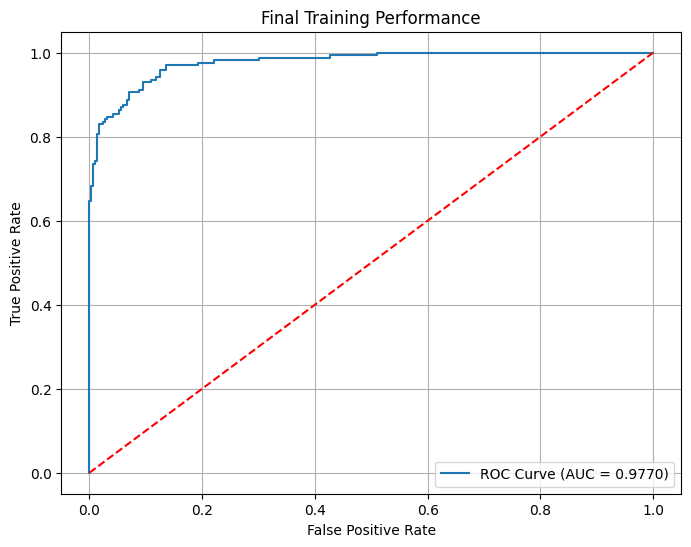

Accuracy Score for Final Testing Performance: 0.8850

Confusion Matrix for Final Testing Performance:
[[68  3]
 [10 32]]


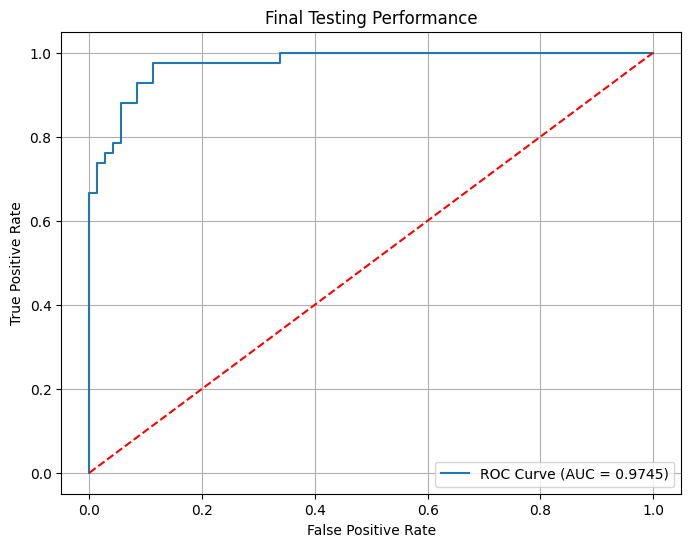


Summary of Average Metrics:


,Train Average,Test Average
Accuracy,0.9112,0.9056
Precision,0.9268,0.9169
Recall,0.8275,0.8214
F1_score,0.8742,0.8654
Auc,0.9747,0.9726


In [67]:
summary_kmeans = run_kmeans_unsupervised(df, iters=30, random_state=42, method="kmeans")

#### (iv) Spectral Clustering

Iteration	Train Accuracy	Test Accuracy
1		0.6316		0.6283
2		0.6316		0.6283
3		0.6272		0.6283
4		0.6316		0.6283
5		0.6316		0.6283
6		0.6316		0.6283
7		0.6272		0.6283
8		0.6272		0.6283
9		0.6316		0.6283
10		0.6316		0.6283
11		0.6294		0.6372
12		0.6272		0.6283
13		0.6294		0.6372
14		0.6272		0.6283
15		0.6316		0.6283
16		0.6272		0.6283
17		0.6294		0.6372
18		0.6294		0.6372
19		0.6316		0.6283
20		0.6294		0.6372
21		0.6294		0.6372
22		0.6294		0.6372
23		0.6316		0.6283
24		0.6316		0.6283
25		0.6316		0.6283
26		0.6316		0.6283
27		0.6316		0.6283
28		0.6294		0.6372
29		0.6316		0.6283
30		0.6601		0.6814

Final Performance Analysis:
Accuracy Score for Final Training Performance: 0.6601

Confusion Matrix for Final Training Performance:
[[286   0]
 [155  15]]


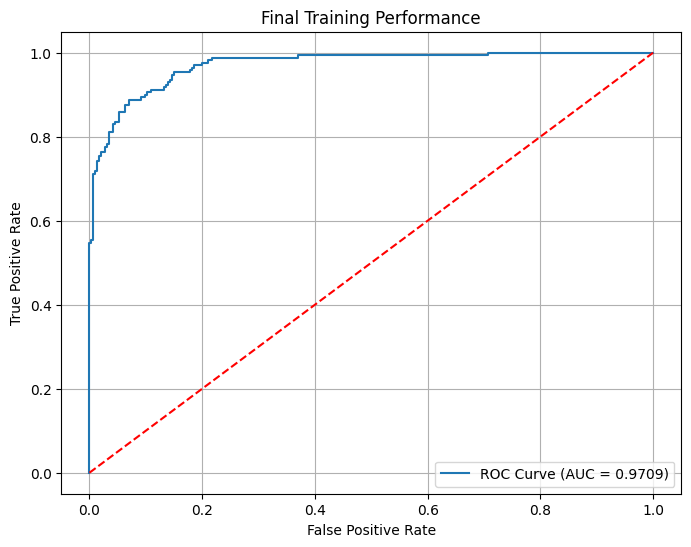

Accuracy Score for Final Testing Performance: 0.6814

Confusion Matrix for Final Testing Performance:
[[71  0]
 [36  6]]


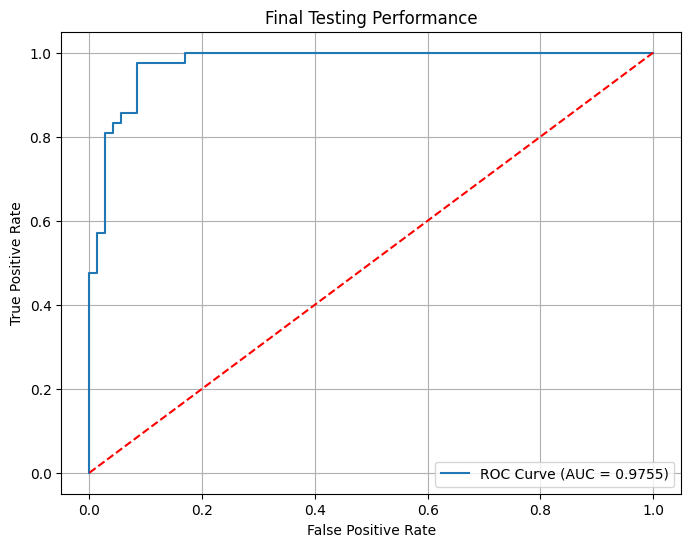


Summary of Average Metrics:


,Train Average,Test Average
Accuracy,0.6311,0.6324
Precision,0.8000,0.3000
Recall,0.0104,0.0111
F1_score,0.0202,0.0207
Auc,0.8951,0.3748


In [70]:
summary_kmeans_spectral = run_kmeans_unsupervised(df, iters=30, random_state=42, method="spectral")

#### (iv) Compare

In [71]:
df_summary_kmeans = pd.DataFrame([summary_kmeans]) if isinstance(summary_kmeans, dict) else summary_kmeans
df_summary_kmeans_spectral = pd.DataFrame([summary_kmeans_spectral]) if isinstance(summary_kmeans_spectral, dict) else summary_kmeans_spectral
df_supervised_results = pd.DataFrame(supervised_results) if isinstance(supervised_results, list) else supervised_results
df_semi_supervised_results = pd.DataFrame(semi_supervised_results) if isinstance(semi_supervised_results, list) else semi_supervised_results

df_semi_supervised_results_transposed = df_semi_supervised_results.T
df_summary_kmeans_transposed = df_summary_kmeans.T
df_summary_kmeans_spectral_transposed = df_summary_kmeans_spectral.T
df_supervised_results_transposed = df_supervised_results.T

print("supervised")
print(df_supervised_results_transposed)
print("\n===============================================================================")
print("semi-supervised")
print(df_semi_supervised_results_transposed)
print("\n===============================================================================")
print("kmeans")
print(df_summary_kmeans_transposed)
print("\n===============================================================================")
print("spectral")
print(df_summary_kmeans_spectral_transposed)

supervised
               Accuracy  Precision  Recall  F1_score     Auc
Train Average    0.9859     0.9930  0.9690    0.9808  0.9968
Test Average     0.9752     0.9848  0.9484    0.9659  0.9941

semi-supervised
               Accuracy  Precision  Recall  F1_score     Auc
Train Average    0.9760     0.9813  0.9539    0.9672  0.9946
Test Average     0.9652     0.9702  0.9357    0.9522  0.9902

kmeans
               Accuracy  Precision  Recall  F1_score     Auc
Train Average    0.9112     0.9268  0.8275    0.8742  0.9747
Test Average     0.9056     0.9169  0.8214    0.8654  0.9726

spectral
               Accuracy  Precision  Recall  F1_score     Auc
Train Average    0.6311        0.8  0.0104    0.0202  0.8951
Test Average     0.6324        0.3  0.0111    0.0207  0.3748


From the comparison above, it is evident that supervised and semi-supervised learning methods significantly outperform unsupervised and spectral clustering methods. While unsupervised methods are less effective, they still provide a baseline for classification without labeled data. In terms of accuracy, the ranking is as follows: supervised learning achieves the highest performance, followed by semi-supervised learning, unsupervised learning, and finally spectral clustering, which exhibits the weakest performance.

## 2. Active Learning Using Support Vector Machines

### (a) Download the banknote authentication Data Set

In [ ]:
sed 's/ \+/,/g' data_banknote_authentication.data > data_banknote_authentication.csv

In [129]:
df_2 = pd.read_csv("./data/data_banknote_authentication.csv", header = None)
df_2.columns = ['variance', 'skewness', 'curtosis', 'entropy', 'class']
df_2.head()
#print(df_2.shape[0])

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [130]:
print(df_2.shape[0])

1372


In [131]:
def random_split_data(df_train):    
    test_index = np.random.choice(1372, 472, replace = False)
    temp_list = []
    for i in range(df_train.shape[0]):
        if i not in test_index:
            temp_list.append(i); 
    train_index = np.array(temp_list)
    x_train = df_train.iloc[train_index]
    x_test = df_train.iloc[test_index]
    return x_train, x_test

### (b) Repeat each of the following two procedures 50 times

#### (i) Passive

In [132]:
def passive_learning(x_train, y_train, x_test, y_test, kwargs):
    all_index = np.arange(x_train.shape[0])
    new_index, accuracy = [], []
    # randomly select 10 samples from the pool
    while len(all_index) > 0:
        np.random.shuffle(all_index)
        pool, all_index = all_index[:10], all_index[10:]
        new_index.extend(pool)
        x_train_new, y_train_new = x_train.iloc[new_index], y_train.iloc[new_index]
        # parameter grid for LinearSVC
        model = GridSearchCV(
            estimator=LinearSVC(penalty='l1', dual=False),
            param_grid=kwargs['param_grid'],
            scoring=kwargs['scoring'],
            n_jobs=1,  # Disable parallelism
            cv=StratifiedKFold(5, shuffle=True, random_state=42)
        )
        model.fit(x_train_new, y_train_new)
        predictions = model.predict(x_test)
        result = classification_report(y_test, predictions, output_dict=True)
        accuracy.append(result['accuracy'])
    return accuracy

In [133]:
def active_learning(x_train, y_train, x_test, y_test, kwargs):
    all_indices = np.arange(x_train.shape[0])
    selected_indices = []
    accuracies = []
    # randomly initialize the pool with 10 samples
    np.random.shuffle(all_indices)
    pool, all_indices = all_indices[:10], all_indices[10:]
    selected_indices.extend(pool)
    # learning loop until all samples are selected
    while len(selected_indices) <= 900:
        x_train_pool = x_train.iloc[selected_indices]
        y_train_pool = y_train.iloc[selected_indices]
        # parameter grid for LinearSVC
        model = GridSearchCV(
            estimator=LinearSVC(penalty='l1', dual=False),
            param_grid=kwargs['param_grid'],
            scoring=kwargs['scoring'],
            n_jobs=1,  # to avoid parallelism
            cv=StratifiedKFold(5, shuffle=True, random_state=42)
        )
        model.fit(x_train_pool, y_train_pool)
        predictions = model.predict(x_test)
        report = classification_report(y_test, predictions, output_dict=True)
        accuracies.append(report['accuracy'])
        # exit if all samples are already selected
        if len(all_indices) == 0:
            break
        # decision function to find samples closest to the hyperplane
        decision_function = model.decision_function(x_train.iloc[all_indices])
        sorted_indices = np.argsort(np.abs(decision_function))[:10]  # top 10 closest to the decision boundary
        pool = all_indices[sorted_indices]
        all_indices = np.delete(all_indices, sorted_indices)
        # add the new samples to the training pool
        selected_indices.extend(pool)
    return accuracies


In [134]:
# controller function for active and passive learning
def monte_carlo(df_train, iters, _type):
    kwargs = {
        'param_grid': {'C': np.logspace(-2, 3, 10)},  #reduced parameters
        'scoring': 'accuracy',
        'cv': StratifiedKFold(5, shuffle=True, random_state=42),
        'n_jobs': -1  
    }
    learning_curve = []
    print('Iteration\tTrain Accuracy\tTest Accuracy')
    # for 50 iteratons
    for i in range(iters):
        df_train_new, df_test_new = random_split_data(df_train)
        x_train, y_train = df_train_new.iloc[:, :-1], df_train_new.iloc[:, -1]
        x_test, y_test = df_test_new.iloc[:, :-1], df_test_new.iloc[:, -1]
        x_train, x_test = normalize_data(x_train, x_test)
        x_train, x_test = pd.DataFrame(x_train), pd.DataFrame(x_test)
        # condition for active and passive learning
        if _type == 'passive':
            accuracy = passive_learning(x_train, y_train, x_test, y_test, kwargs)
        else:
            accuracy = active_learning(x_train, y_train, x_test, y_test, kwargs)
        # add accuracy to learning curve
        learning_curve.append(accuracy)
        print(f'{i + 1}\t\t{round(accuracy[0], 4)}\t\t{round(accuracy[-1], 4)}')
    learning_curve = np.mean(np.array(learning_curve), axis=0)
    return learning_curve

In [123]:
passive_curve = monte_carlo(df_2, iters=50, _type='passive')

Iteration	Train Accuracy	Test Accuracy
1		0.9068		0.9915
2		0.9047		0.9936
3		0.7352		0.9831
4		0.9534		0.9894
5		0.875		0.9873
6		0.8411		0.9809
7		0.8665		0.9831
8		0.7246		0.9915
9		0.8708		0.9958
10		0.9025		0.9979
11		0.9195		0.9915
12		0.5593		0.9809
13		0.8941		0.9915
14		0.9852		0.9936
15		0.8496		0.9915
16		0.553		0.9894
17		0.8983		0.9852
18		0.8093		0.9852
19		0.8581		0.9873
20		0.5593		0.9894
21		0.9407		0.9852
22		0.9915		0.9936
23		0.5466		0.9873
24		0.9174		0.9894
25		0.8114		0.9831
26		0.8475		0.9894
27		0.536		0.9873
28		0.8093		0.9894
29		0.7606		0.9894
30		0.8517		0.9852
31		0.8475		0.9894
32		0.9386		0.9809
33		0.8792		0.9958
34		0.8453		0.9894
35		0.553		0.9873
36		0.8199		0.9894
37		0.8517		0.9894
38		0.964		0.9873
39		0.6886		0.9894
40		0.8326		0.9958
41		0.9682		0.9767
42		0.8496		0.9873
43		0.8602		0.9936
44		0.8263		0.9936
45		0.9513		0.9894
46		0.8475		0.9873
47		0.8729		0.9894
48		0.8559		0.9831
49		0.9746		0.9852
50		0.9809		0.9915


#### (ii) Active

In [124]:
active_curve = monte_carlo(df_2, iters=50, _type='active')

Iteration	Train Accuracy	Test Accuracy
1		0.8496		0.9936
2		0.8581		0.9958
3		0.8496		0.9725
4		0.9004		0.9936
5		0.8432		0.9915
6		0.8347		0.9852
7		0.8581		0.9936
8		0.803		0.9873
9		0.9025		0.9852
10		0.8581		0.9873
11		0.9661		0.9915
12		0.8559		0.9873
13		0.5487		0.9915
14		0.8432		0.9958
15		0.8347		0.9852
16		0.8602		0.9936
17		0.9237		0.9915
18		0.6271		0.9915
19		0.8517		0.9894
20		0.8538		0.9936
21		0.9619		0.9873
22		0.9534		0.9915
23		0.8411		0.9873
24		0.9597		0.9873
25		0.9258		0.9873
26		0.947		0.9936
27		0.9703		0.9852
28		0.8538		0.9936
29		0.9089		0.9915
30		0.8475		0.9915
31		0.8729		0.9915
32		0.7839		0.9915
33		0.8771		0.9936
34		0.5508		0.9831
35		0.8453		0.9958
36		0.9195		0.9873
37		0.8538		0.9936
38		0.8496		0.9936
39		0.8496		0.9894
40		0.7203		0.9936
41		0.8114		0.9936
42		0.8538		0.9873
43		0.8093		0.9894
44		0.8453		0.9682
45		0.8432		0.9915
46		0.786		0.9936
47		0.8623		0.9894
48		0.7987		0.9873
49		0.9216		0.9894
50		0.8581		0.9915


### (c) Average the 50 test errors

In [125]:
def plot_learning_curve(active, passive):
    _, ax = plt.subplots(figsize=(8, 6))
    x = 10 * np.arange(1, len(passive) + 1)
    ax.plot(x, 1 - np.array(passive), label='Passive Learning', marker='o', color= 'red')
    ax.plot(x, 1 - np.array(active), label='Active Learning', marker='x', color='blue')
    ax.set_title('Learning Curve')
    ax.set_xlabel('Training Pool Size')
    ax.set_ylabel('Test Error')
    ax.legend()
    plt.grid()
    plt.show()

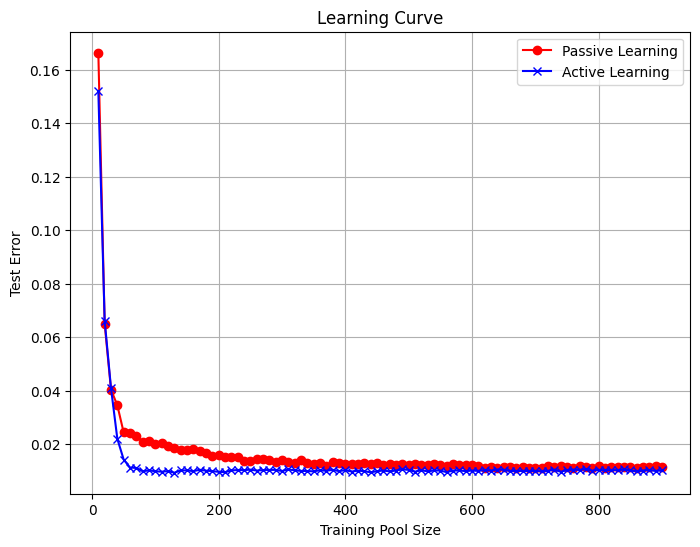

In [126]:
plot_learning_curve(active_curve, passive_curve)

From the plot above, active learning proves to be highly efficient in reducing test error with fewer labeled data points, particularly in the initial stages of the learning process. In contrast, passive learning requires substantially more labeled data to achieve similar performance. Therefore, active learning is more advantageous when data labeling is expensive or resource-intensive.

### Citations 
- https://stackoverflow.com/questions/37405865/convert-txt-to-csv-in-shell
- https://mohitmishra786687.medium.com/the-curse-of-local-minima-how-to-escape-and-find-the-global-minimum-fdabceb2cd6a#:~:text=Change%20the%20learning%20rate%3A%20A,effective%20at%20avoiding%20local%20minima.
- https://stackoverflow.com/questions/54240144/distance-between-nodes-and-the-centroid-in-a-kmeans-cluster
- https://stackoverflow.com/questions/50491630/randomly-split-a-numpy-array
- https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html
- https://blog.mindresearch.org/blog/active-learning
- https://pmc.ncbi.nlm.nih.gov/articles/PMC6765278/#:~:text=Students%20learn%20more%20when%20they,courses%20(1–6)
- https://neptune.ai/blog/monte-carlo-simulation
- https://www.geeksforgeeks.org/supervised-unsupervised-learning/


### ChatGPT Prompt & Responses

prompt: I am trying to train an L1 penalized SBM to classify the data, that uses 5-fold cross validation to choose penalty param. give me syntax.  

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

# Define the parameter grid for the penalty parameter (C)
param_grid = {'C': np.logspace(-3, 3, 10)}  # Logarithmic scale for penalty parameter

# Define the model with L1 penalty
svm_model = LinearSVC(penalty='l1', dual=False, max_iter=10000)

# Set up 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use GridSearchCV to find the best penalty parameter
grid_search = GridSearchCV(
    estimator=svm_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1
)

# Train the model
grid_search.fit(x_train, y_train)

# Get the best model and penalty parameter
best_model = grid_search.best_estimator_
best_param = grid_search.best_params_['C']

# Evaluate the model on the test set
y_pred = best_model.predict(x_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Output the best penalty parameter
print(f"Best penalty parameter (C): {best_param}")

prompt: following upon the query above, i want to find unlabeled data point which is the fartest from the decsiiton bondary and add it to labeled data and retrian it. thus i want to continue this loop (use while loop) until all unlabeled data are used. give me syntax for it 

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd

def run_svm(X_labeled, y_labeled, X_unlabeled, y_test, X_test, param_grid, random_state=None):
    """
    Train an L1-penalized SVM with active learning by adding the farthest point from the decision boundary.
    
    Args:
        X_labeled (pd.DataFrame): Initial labeled feature set.
        y_labeled (pd.Series): Initial labeled target set.
        X_unlabeled (pd.DataFrame): Unlabeled feature set.
        y_test (pd.Series): Test target set for evaluation.
        X_test (pd.DataFrame): Test feature set for evaluation.
        param_grid (dict): Grid for cross-validation hyperparameter tuning.
        random_state (int, optional): Random state for reproducibility.
        
    Returns:
        history (list): List of test accuracy scores at each iteration.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    history = []  # To store test accuracy at each iteration
    unlabeled_indices = np.arange(X_unlabeled.shape[0])  # Track indices of the unlabeled set
    
    while len(unlabeled_indices) > 0:
        # Step 1: Train the SVM with the labeled dataset
        model = GridSearchCV(
            estimator=LinearSVC(penalty='l1', dual=False, max_iter=5000),
            param_grid=param_grid,
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )
        model.fit(X_labeled, y_labeled)
        
        # Step 2: Predict decision function scores for the unlabeled set
        decision_scores = model.decision_function(X_unlabeled)
        # Find the farthest point from the decision boundary
        farthest_idx = np.argmax(np.abs(decision_scores))
        farthest_point = X_unlabeled.iloc[farthest_idx]
        
        # Step 3: Add the farthest point to the labeled set
        X_labeled = pd.concat([X_labeled, farthest_point.to_frame().T], axis=0)
        y_labeled = pd.concat([y_labeled, pd.Series([np.nan], index=[farthest_idx])], axis=0)
        
        # Remove the added point from the unlabeled set
        X_unlabeled = X_unlabeled.drop(index=farthest_idx)
        unlabeled_indices = np.delete(unlabeled_indices, farthest_idx)
        
        # Step 4: Evaluate the model on the test set
        y_pred = model.predict(X_test)
        test_accuracy = np.mean(y_pred == y_test)
        history.append(test_accuracy)
        
        print(f"Iteration {len(history)} - Test Accuracy: {test_accuracy:.4f}")
        
    return history

prompt: give me function that calculates the distance of each data points to the assigned cluster center and compute pseudo prob (proba) for two clusters. 

In [ ]:
import numpy as np
from scipy.special import softmax

def calculate_distances_and_pseudo_prob(X, centers, labels):
    """
    Calculate distances of data points to their assigned cluster centers 
    and compute pseudo-probabilities for two clusters.

    Parameters:
    - X: np.ndarray of shape (n_samples, n_features)
        The data points.
    - centers: np.ndarray of shape (n_clusters, n_features)
        The cluster centers.
    - labels: np.ndarray of shape (n_samples,)
        The cluster labels for each data point.

    Returns:
    - distances: np.ndarray of shape (n_samples,)
        The distance of each data point to its assigned cluster center.
    - pseudo_probabilities: np.ndarray of shape (n_samples, 2)
        Pseudo-probabilities for each data point belonging to each cluster.
    """
    n_samples = X.shape[0]
    n_clusters = centers.shape[0]

    if n_clusters != 2:
        raise ValueError("This function is designed for two clusters only.")

    # Compute distances to both cluster centers
    all_distances = np.zeros((n_samples, n_clusters))
    for i, center in enumerate(centers):
        all_distances[:, i] = np.linalg.norm(X - center, axis=1)

    # Distance to the assigned cluster center
    distances = np.array([all_distances[i, labels[i]] for i in range(n_samples)])

    # Compute pseudo-probabilities using softmax on negative distances
    pseudo_probabilities = softmax(-all_distances, axis=1)

    return distances, pseudo_probabilities


prompt: give me function for majority voting that majority poll becomes the label predicted by k-means for the members of each cluster, that it should read labels for 30 data ponts and take majority poll withn them. 

In [ ]:
import numpy as np
from collections import Counter

def majority_vote_with_nearest(labels, distances, true_labels, n_nearest=30):
    """
    Assigns a majority label to each cluster based on the true labels
    of the nearest `n_nearest` data points in each cluster.

    Parameters:
    - labels: np.ndarray of shape (n_samples,)
        Cluster labels predicted by k-means for each data point.
    - distances: np.ndarray of shape (n_samples,)
        Distances of each data point to its cluster center.
    - true_labels: np.ndarray of shape (n_samples,)
        True labels of the data points.
    - n_nearest: int, optional (default=30)
        Number of nearest data points to consider for majority voting.

    Returns:
    - cluster_to_label: dict
        A mapping of cluster index to the majority true label.
    - updated_labels: np.ndarray of shape (n_samples,)
        Updated labels for all data points based on the majority voting.
    """
    unique_clusters = np.unique(labels)
    cluster_to_label = {}
    updated_labels = labels.copy()

    for cluster in unique_clusters:
        # Find indices of points in the current cluster
        cluster_indices = np.where(labels == cluster)[0]

        # Get distances for points in the cluster and sort by distance
        cluster_distances = distances[cluster_indices]
        nearest_indices = cluster_indices[np.argsort(cluster_distances)[:n_nearest]]

        # Find true labels for the nearest points and compute the majority label
        nearest_true_labels = true_labels[nearest_indices]
        majority_label = Counter(nearest_true_labels).most_common(1)[0][0]

        # Map the cluster to its majority label
        cluster_to_label[cluster] = majority_label

        # Update labels for all points in the cluster
        updated_labels[cluster_indices] = majority_label

    return cluster_to_label, updated_labels

i am trying to split_data() which chooses 472 data points randomly as test and remainng 900 as training (total of 1372). need to repeat ths procedure 50 times, it should return x_train and x_test. thus use iloc method. give me syntax. 

In [ ]:
import numpy as np
import pandas as pd

def split_data(df, test_size=472, iterations=50, random_state=42):
    """
    Splits the data into training and test sets multiple times using iloc.
    
    Args:
        df (pd.DataFrame): The dataset to split.
        test_size (int): Number of data points for the test set.
        iterations (int): Number of times to repeat the split.
        random_state (int): Seed for reproducibility.
        
    Returns:
        splits (list): A list of tuples [(x_train1, x_test1), ..., (x_train50, x_test50)].
    """
    np.random.seed(random_state)
    splits = []
    
    for i in range(iterations):
        # Randomly sample indices for the test set
        test_indices = np.random.choice(df.index, size=test_size, replace=False)
        train_indices = np.array([idx for idx in df.index if idx not in test_indices])
        
        # Split the data using iloc
        x_test = df.iloc[test_indices]
        x_train = df.iloc[train_indices]
        splits.append((x_train, x_test))
    
    return splits

# Example Usage:
# Assuming `df` is your dataframe with 1372 data points
splits = split_data(df, test_size=472, iterations=50, random_state=42)

# Access the first split
x_train_1, x_test_1 = splits[0]
print(f"x_train shape: {x_train_1.shape}")
print(f"x_test shape: {x_test_1.shape}")


prompt: I am trying to write function for active_learning. it trains SVM with a pool of 10 randomly selected data points using 5-fold cross validation. choose 10 closest data points in training to hyperplane. it should give 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. give me syntax 

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

def active_learning(x_train, y_train, x_test, y_test, param_grid, random_state=42):
    """
    Active learning implementation to train SVMs incrementally by selecting 10 closest points to the decision boundary.

    Args:
        x_train (pd.DataFrame): Training data features.
        y_train (pd.Series): Training data labels.
        x_test (pd.DataFrame): Test data features.
        y_test (pd.Series): Test data labels.
        param_grid (dict): Hyperparameter grid for SVM (e.g., {'C': [0.1, 1, 10]}).
        random_state (int): Random seed for reproducibility.

    Returns:
        test_errors (list): List of test errors for 90 SVMs.
    """
    np.random.seed(random_state)
    test_errors = []
    all_indices = np.arange(x_train.shape[0])
    selected_indices = []

    # Randomly select the first 10 data points
    np.random.shuffle(all_indices)
    pool, all_indices = all_indices[:10], all_indices[10:]
    selected_indices.extend(pool)

    while len(selected_indices) <= 900:
        # Prepare training data with selected indices
        x_train_pool = x_train.iloc[selected_indices]
        y_train_pool = y_train.iloc[selected_indices]

        # Train SVM with L1 penalty using 5-fold cross validation
        model = GridSearchCV(
            estimator=SVC(kernel="linear", probability=True),
            param_grid=param_grid,
            scoring="accuracy",
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state),
            n_jobs=-1
        )
        model.fit(x_train_pool, y_train_pool)

        # Test the model on the test set
        y_pred = model.predict(x_test)
        test_error = 1 - accuracy_score(y_test, y_pred)
        test_errors.append(test_error)

        # If no data left in all_indices, break
        if len(all_indices) == 0:
            break

        # Find the 10 closest points to the decision boundary
        decision_values = model.decision_function(x_train.iloc[all_indices])
        closest_indices = np.argsort(np.abs(decision_values))[:10]

        # Update selected_indices and all_indices
        pool = all_indices[closest_indices]
        all_indices = np.delete(all_indices, closest_indices)
        selected_indices.extend(pool)

    return test_errors

# Example Usage:
# Assuming `x_train`, `y_train`, `x_test`, `y_test` are preprocessed and defined
param_grid = {'C': np.logspace(-3, 3, 7)}
test_errors = active_learning(x_train, y_train, x_test, y_test, param_grid, random_state=42)

# Print the test errors for each iteration
print("Test Errors for Active Learning:")
print(test_errors)